In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (replace 'your_dataset.csv' with the actual dataset file)
data = pd.read_csv('processed_data_PCA.csv')

# Assuming the last column is the target variable (y), and the rest are features (X)
X = data.drop('y', axis=1)  # Assuming 'y' is your target column
y = data['y']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example: Check the shape of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (36167, 53)
X_test shape: (9042, 53)


# Model 

Epoch 1/20, Loss: 0.3164, Accuracy: 0.8864
Epoch 2/20, Loss: 0.2957, Accuracy: 0.8932
Epoch 3/20, Loss: 0.2908, Accuracy: 0.8931
Epoch 4/20, Loss: 0.2880, Accuracy: 0.8943
Epoch 5/20, Loss: 0.2848, Accuracy: 0.8948
Epoch 6/20, Loss: 0.2827, Accuracy: 0.8958
Epoch 7/20, Loss: 0.2813, Accuracy: 0.8961
Epoch 8/20, Loss: 0.2796, Accuracy: 0.8968
Epoch 9/20, Loss: 0.2784, Accuracy: 0.8962
Epoch 10/20, Loss: 0.2772, Accuracy: 0.8983
Epoch 11/20, Loss: 0.2763, Accuracy: 0.8981
Epoch 12/20, Loss: 0.2742, Accuracy: 0.8986
Epoch 13/20, Loss: 0.2743, Accuracy: 0.8991
Epoch 14/20, Loss: 0.2730, Accuracy: 0.8989
Epoch 15/20, Loss: 0.2717, Accuracy: 0.8997
Epoch 16/20, Loss: 0.2704, Accuracy: 0.9004
Epoch 17/20, Loss: 0.2693, Accuracy: 0.9007
Epoch 18/20, Loss: 0.2690, Accuracy: 0.9011
Epoch 19/20, Loss: 0.2675, Accuracy: 0.9029
Epoch 20/20, Loss: 0.2663, Accuracy: 0.9020


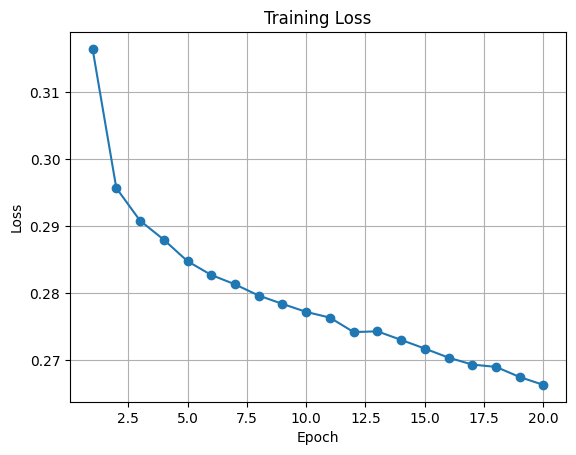

Training Accuracy: 0.9042773799319822
Test Accuracy: 0.8907321389073214
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7951
           1       0.60      0.29      0.39      1091

    accuracy                           0.89      9042
   macro avg       0.75      0.63      0.67      9042
weighted avg       0.87      0.89      0.87      9042



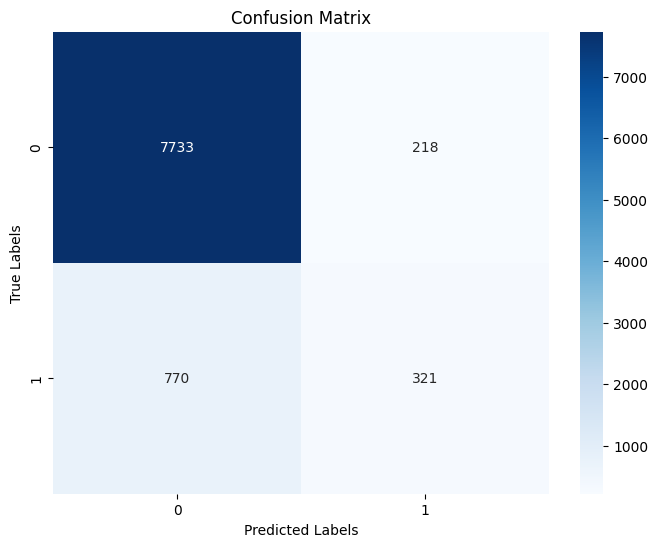

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
torch.manual_seed(42)

# Convert preprocessed DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()                         # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size) # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define model parameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 64               # Number of neurons in the hidden layer
output_size = len(y_train.unique())  # Number of output classes


# Initialize the model
model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training the model
epochs = 20
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_accuracy = correct / total
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Evaluation
model.eval()
y_train_pred = []
y_train_true = []
y_test_pred = []
y_test_true = []

# Training Accuracy
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(y_batch.cpu().numpy())

print("Training Accuracy:", accuracy_score(y_train_true, y_train_pred))

# Test Accuracy
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_true.extend(y_batch.cpu().numpy())

print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred))

# Classification Report for Test Data
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_true, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# # Save the model
# torch.save(model.state_dict(), 'neural_net_model.pth')
# print("Model saved as 'neural_net_model.pth'")


pca model

In [7]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from torch.utils.data import DataLoader, TensorDataset
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure reproducibility
# torch.manual_seed(42)

# # Convert PCA-reduced DataFrames to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_reduced, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test_reduced, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
# X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# # Create DataLoader for batching
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Neural Network Model
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(NeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
#         self.relu = nn.ReLU()                         # Activation function
#         self.fc2 = nn.Linear(hidden_size, output_size) # Output layer

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

# # Define model parameters
# input_size = X_train_reduced.shape[1]  # Number of PCA-reduced features
# hidden_size = 64                       # Number of neurons in the hidden layer
# output_size = len(y_train.unique())    # Number of output classes

# # Initialize the model
# model = NeuralNet(input_size, hidden_size, output_size).to(device)
# criterion = nn.CrossEntropyLoss()  # Loss function for classification
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# # Training the model
# epochs = 20
# losses = []

# for epoch in range(epochs):
#     model.train()
#     epoch_loss = 0
#     correct = 0
#     total = 0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         # Forward pass
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == y_batch).sum().item()
#         total += y_batch.size(0)

#     epoch_accuracy = correct / total
#     losses.append(epoch_loss / len(train_loader))
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

# # Plot training loss
# plt.plot(range(1, epochs + 1), losses, marker='o')
# plt.title("Training Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid()
# plt.show()

# # Evaluation
# model.eval()
# y_train_pred = []
# y_train_true = []
# y_test_pred = []
# y_test_true = []

# # Training Accuracy
# with torch.no_grad():
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         outputs = model(X_batch)
#         _, predicted = torch.max(outputs, 1)
#         y_train_pred.extend(predicted.cpu().numpy())
#         y_train_true.extend(y_batch.cpu().numpy())

# print("Training Accuracy:", accuracy_score(y_train_true, y_train_pred))

# # Test Accuracy
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         outputs = model(X_batch)
#         _, predicted = torch.max(outputs, 1)
#         y_test_pred.extend(predicted.cpu().numpy())
#         y_test_true.extend(y_batch.cpu().numpy())

# print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred))

# # Classification Report for Test Data
# print("Classification Report:")
# print(classification_report(y_test_true, y_test_pred))

# # Confusion Matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix(y_test_true, y_test_pred), annot=True, fmt='d', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()

# # Save the model (optional)
# # torch.save(model.state_dict(), 'neural_net_model_pca.pth')
# # print("Model saved as 'neural_net_model_pca.pth'")


# Tunning 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Evaluate the model
def evaluate_model(model, data_loader, device):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
    return accuracy_score(y_true, y_pred), y_true, y_pred

# Train the model with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        correct_train = 0
        total_train = 0
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)
            
            epoch_loss += loss.item()

        # Calculate training accuracy
        train_accuracy = correct_train / total_train

        # Validate the model
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

# Hyperparameter tuning
def tune_hyperparameters(X_train, y_train, X_test, y_test, hidden_sizes, learning_rates, batch_sizes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_accuracy = 0
    best_hyperparameters = {}

    # Split training data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                # Create DataLoaders
                train_dataset = TensorDataset(torch.tensor(X_train_split.values, dtype=torch.float32),  # Convert to NumPy array
                               torch.tensor(y_train_split.values, dtype=torch.long))  # Convert to NumPy array
                val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32),  # Convert to NumPy array
                             torch.tensor(y_val.values, dtype=torch.long))  # Convert to NumPy array
                test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32),  # Convert to NumPy array
                              torch.tensor(y_test.values, dtype=torch.long))  # Convert to NumPy array

                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Initialize the model
                model = NeuralNet(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=2).to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Train the model
                train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device)

                # Evaluate on validation set
                val_accuracy, _, _ = evaluate_model(model, val_loader, device)

                # Update best hyperparameters
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_hyperparameters = {'hidden_size': hidden_size, 'lr': lr, 'batch_size': batch_size}
                    # Save the best model
                    torch.save(model.state_dict(), "best_NN_model.pth")

                print(f"Hidden Size: {hidden_size}, LR: {lr}, Batch Size: {batch_size}, Val Accuracy: {val_accuracy:.4f}")

    # Evaluate on the test set
    best_model = NeuralNet(input_size=X_train.shape[1], hidden_size=best_hyperparameters['hidden_size'], output_size=2).to(device)
    best_model.load_state_dict(torch.load("best_NN_model.pth"))
    test_accuracy, y_true, y_pred = evaluate_model(best_model, test_loader, device)

    # Print metrics
    print(f"Best Hyperparameters: {best_hyperparameters}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")

    # Classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(y_true, y_pred))

# Example hyperparameter values
hidden_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]

# Assuming X_train, y_train, X_test, y_test are already prepared and normalized
tune_hyperparameters(X_train, y_train, X_test, y_test, hidden_sizes, learning_rates, batch_sizes)


Early stopping triggered after 16 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 16, Val Accuracy: 0.8915
Early stopping triggered after 15 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 32, Val Accuracy: 0.8938
Early stopping triggered after 10 epochs.
Hidden Size: 32, LR: 0.01, Batch Size: 64, Val Accuracy: 0.8926
Early stopping triggered after 8 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 16, Val Accuracy: 0.8952
Early stopping triggered after 13 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 32, Val Accuracy: 0.8956
Early stopping triggered after 12 epochs.
Hidden Size: 32, LR: 0.001, Batch Size: 64, Val Accuracy: 0.8947
Hidden Size: 32, LR: 0.0001, Batch Size: 16, Val Accuracy: 0.8965
Hidden Size: 32, LR: 0.0001, Batch Size: 32, Val Accuracy: 0.8973
Hidden Size: 32, LR: 0.0001, Batch Size: 64, Val Accuracy: 0.8958
Early stopping triggered after 14 epochs.
Hidden Size: 64, LR: 0.01, Batch Size: 16, Val Accuracy: 0.8955
Early stopping triggered after 7 epochs.
Hidden Size: 64, 

C:\Users\wasif\AppData\Local\Temp\ipykernel_13320\611363210.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_NN_model.pth"))

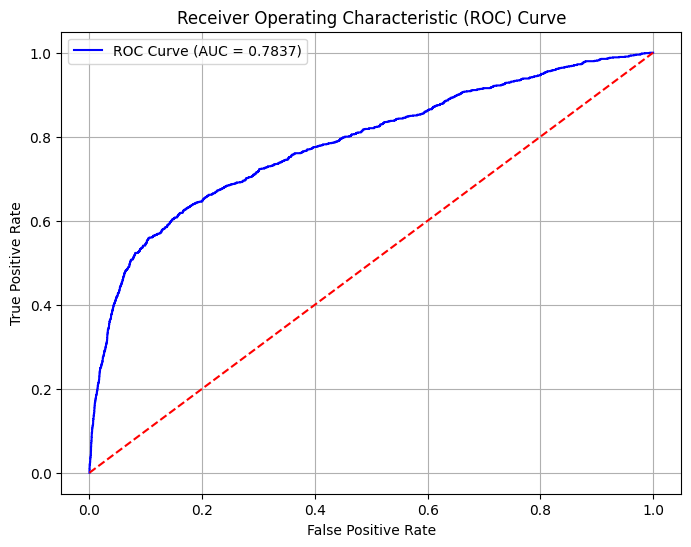

Test ROC-AUC: 0.7837


In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Function to calculate and plot ROC-AUC
def calculate_roc_auc(model, data_loader, device, plot_roc=False):
    model.eval()
    y_true, y_probs = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
            y_true.extend(y_batch.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    
    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_true, y_probs) if len(set(y_true)) > 1 else None
    
    # Optionally plot ROC curve
    if plot_roc and roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.grid()
        plt.show()
    
    return roc_auc

# Example usage:
# Assuming `test_loader` is your DataLoader for the test set and `best_model` is your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roc_auc = calculate_roc_auc(best_model, test_loader, device, plot_roc=True)
print(f"Test ROC-AUC: {roc_auc:.4f}")


C:\Users\wasif\AppData\Local\Temp\ipykernel_13320\719535319.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_NN_model.pth"))


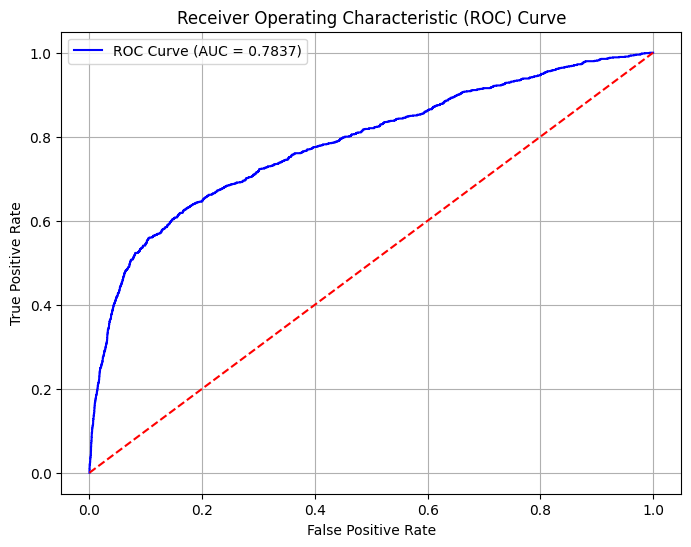

Test ROC-AUC: 0.7837


In [12]:
# Define the model architecture with correct hidden size
best_hidden_size = 32  # Replace with the hidden size used during training
best_model = NeuralNet(input_size=X_train.shape[1], hidden_size=best_hidden_size, output_size=2).to(device)

# Load the best model from saved file
best_model.load_state_dict(torch.load("best_NN_model.pth"))

# Define the test_loader
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32),
                              torch.tensor(y_test.values, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate and plot ROC-AUC
roc_auc = calculate_roc_auc(best_model, test_loader, device, plot_roc=True)
print(f"Test ROC-AUC: {roc_auc:.4f}")


pca 

# Save

In [21]:
# # Save the entire model
# torch.save(model.state_dict(), "best_model_full.pth")
# print("Full model saved successfully!")
